In [1]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import shutil
import numpy as np
import random

from ultralytics import YOLO
from PIL import Image

# EDA

In [2]:
# Metadata para ordenar el entrenamiento
metadata_path = 'datasets\Labeled Stomatal Images.csv'
metadata = pd.read_csv(metadata_path)

In [3]:
metadata.head()

,FileName,Species,ScientificName,Magnification,Witdh,Heigth,Resolution
0,STMHD0001,Nuttall oak,Quercus texana Buckley,100,1024,768,118
1,STMHD0002,Nuttall oak,Quercus texana Buckley,100,1024,768,118
2,STMHD0003,Nuttall oak,Quercus texana Buckley,100,1024,768,118
3,STMHD0004,Nuttall oak,Quercus texana Buckley,100,1024,768,118
4,STMHD0005,Nuttall oak,Quercus texana Buckley,100,1024,768,118


In [4]:
metadata.Species.unique()

array(['Nuttall oak', 'Shumard oak', 'American elm', 'American Holly', 'Cherrybark oak', 'Shagbark hickory', 'Swamp chestnut oak', 'Water oak', 'Willow oak', 'Winged elm', 'Ash', 'Deerberry', 'Leatherwood', 'Red maple', 'Post oak', 'Black gum', 'Willow', 'Poplar'], dtype=object)

In [4]:
# Calcular el número total de imágenes
total_images = len(metadata)

# Calcular la media y desviación estándar de Width y Height
mean_width = metadata['Witdh'].mean()
std_width = metadata['Witdh'].std()
mean_height = metadata['Heigth'].mean()
std_height = metadata['Heigth'].std()

# Número de especies únicas
unique_species = metadata['Species'].nunique()

# Frecuencia de cada especie
species_frequency = metadata['Species'].value_counts()

# Frecuencia de resoluciones (Width x Height)
resolution_frequency = metadata.groupby(['Witdh', 'Heigth']).size()

# Media de la magnificación
mean_magnification = metadata['Magnification'].mean()

# Frecuencia de magnificación
magnification_frequency = metadata['Magnification'].value_counts()

# Print results
print("Total de imágenes:", total_images)
print("Witdh promedio:", mean_width, "Desviación estándar del ancho:", std_width)
print("Heigth promedio:", mean_height, "Desviación estándar de la altura:", std_height)
print("Número de especies únicas:", unique_species)
print("Frecuencia de cada especie:", species_frequency)
print("Frecuencia de resoluciones:", resolution_frequency)
print("Magnificación promedio:", mean_magnification)
print("Frecuencia de magnificaciones:", magnification_frequency)


Total de imágenes: 10715
Witdh promedio: 1407.319085394307 Desviación estándar del ancho: 495.5886844096622
Heigth promedio: 1055.4893140457302 Desviación estándar de la altura: 371.6915133072467
Número de especies únicas: 18
Frecuencia de cada especie: Species
Poplar                3068
Nuttall oak           2975
Shumard oak           1612
Water oak              653
Willow oak             568
Cherrybark oak         286
Winged elm             205
Ash                    200
Post oak               196
American elm           185
Leatherwood            130
Swamp chestnut oak     129
American Holly         100
Red maple              100
Shagbark hickory        91
Deerberry               85
Willow                  82
Black gum               50
Name: count, dtype: int64
Frecuencia de resoluciones: Witdh  Heigth
1024   768       6704
2048   1536      4011
dtype: int64
Magnificación promedio: 270.32197853476436
Frecuencia de magnificaciones: Magnification
200    5740
400    4170
100     805
Nam

In [5]:
# Ruta al directorio donde están almacenados tus archivos .txt
path = 'datasets/train/labels'

# Lista para almacenar el número de líneas de cada archivo
line_counts = []

# Recorrer cada archivo en el directorio
for filename in os.listdir(path):
    if filename.endswith('.txt'):  # Asegurarse de procesar solo archivos .txt
        with open(os.path.join(path, filename), 'r') as file:
            lines = file.readlines()
            line_counts.append(len(lines))  # Añadir el número de líneas

# Calcular la media y la desviación estándar de line_counts
if line_counts:
    mean_boxes = np.mean(line_counts)
    variance = np.var(line_counts)
    std_dev = variance ** 0.5
    print(f'Total de bounding boxes: {sum(line_counts)}')
    print(f'Media de bounding boxes por imagen: {mean_boxes}')
    print(f'Desviación estándar de bounding boxes por imagen: {std_dev}')
else:
    print("No se encontraron archivos .txt en el directorio.")

Total de bounding boxes: 844700
Media de bounding boxes por imagen: 79.46378174976482
Desviación estándar de bounding boxes por imagen: 68.45524631790693


# Preprocesamiento

In [4]:
#Mediciones 1 plant-out
def onePlantOut(plant_name):
  main_folder = 'datasets'

  train_images_folder = os.path.join(main_folder, 'train/images')
  train_labels_folder = os.path.join(main_folder, 'train/labels')
  val_images_folder = os.path.join(main_folder, 'val/images')
  val_labels_folder = os.path.join(main_folder, 'val/labels')

  folders = [train_images_folder, train_labels_folder, val_images_folder, val_labels_folder]

  # Sino existen los directorios
  for folder in folders:
      if not os.path.exists(folder):
          os.makedirs(folder)

  # Seleccionar la planta a medir su rendimiento
  plant = plant_name
  trainFiles = metadata[metadata['Species'] != plant]['FileName'].tolist()
  valFiles = metadata[metadata['Species'] == plant]['FileName'].tolist()

  for folder in folders:
    for file in os.listdir(folder):
      if file.split(".")[0] in trainFiles:
        if file.endswith(".jpg"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/images', file))
        elif file.endswith(".txt"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/labels', file))

  for folder in folders:
    for file in os.listdir(folder):
      if file.split(".")[0] in valFiles:
        if file.endswith(".jpg"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/images', file))
        elif file.endswith(".txt"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/labels', file))

def holdOut(random_seed = 42, test_size = 0.2):
    random.seed(random_seed)
    main_folder = 'datasets'

    train_images_folder = os.path.join(main_folder, 'train/images')
    train_labels_folder = os.path.join(main_folder, 'train/labels')
    val_images_folder = os.path.join(main_folder, 'val/images')
    val_labels_folder = os.path.join(main_folder, 'val/labels')

    folders = [train_images_folder, train_labels_folder, val_images_folder, val_labels_folder]

  # Sino existen los directorios
    for folder in folders:
        if not os.path.exists(folder):
            os.makedirs(folder)

    # Obtener todos los archivos de la columna 'FileName'
    all_files = metadata['FileName'].tolist()

    # Mezclar aleatoriamente los archivos
    random.shuffle(all_files,)

    split_idx = int((1-test_size) * len(all_files))
    trainFiles = all_files[:split_idx]
    valFiles = all_files[split_idx:]

    for folder in folders:
        for file in os.listdir(folder):
            if file.split(".")[0] in trainFiles:
                if file.endswith(".jpg"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/images', file))
                elif file.endswith(".txt"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/labels', file))
    
    for folder in folders:
        for file in os.listdir(folder):
            if file.split(".")[0] in valFiles:
                if file.endswith(".jpg"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/images', file))
                elif file.endswith(".txt"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/labels', file))



In [5]:
holdOut(random_seed = 42, test_size = 0.2)
# onePlantOut("Nuttall oak")

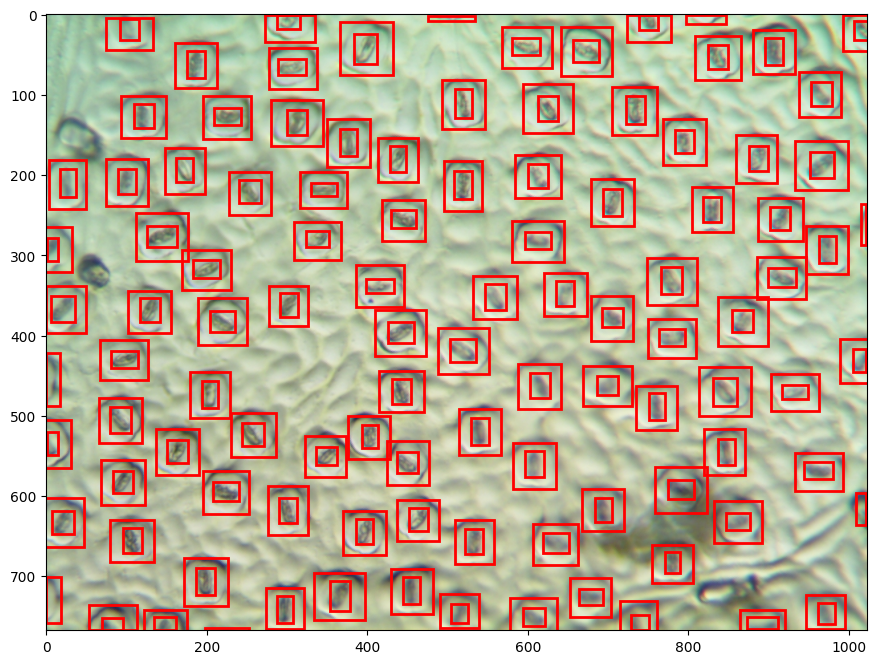

In [6]:
PATH_images = "datasets/train/images"
PATH_labels = "datasets/train/labels"
plant_type = '/STMHD'
number = "0005"
image_path = f"{PATH_images}{plant_type}{number}.jpg"
txt_path = f"{PATH_labels}{plant_type}{number}.txt"

def show_image(image_path, txt_path):
    img = cv2.imread(image_path)
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # Leer y mostrar el contenido del archivo .txt
    with open(txt_path, 'r') as file:
        annotations = file.readlines()

    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation.split())
        x = (x_center - width / 2) * img.shape[1]
        y = (y_center - height / 2) * img.shape[0]
        w = width * img.shape[1]
        h = height * img.shape[0]
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()
show_image(image_path, txt_path)

# YOLO

In [10]:
modelSimple = YOLO('Modelos\yolov10\yolov10n.pt')
modelAdjust = YOLO('Modelos\yolov10\yolov10n.pt')

# Entrenar el modelo
modelSimple.train(data='YOLO8INFO.yaml', epochs=30, imgsz=640, batch=16, device=0) #Simple
modelSimple.save('Modelos\yolov10\HoldOutSimpleYolov10n.pt')

New https://pypi.org/project/ultralytics/8.3.5 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: task=detect, mode=train, model=Modelos\yolov10\yolov10n.pt, data=YOLO8INFO.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show

train: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\train\labels... 8572 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8572/8572 [00:06<00:00, 1227.01it/s]


train: New cache created: C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\train\labels.cache


val: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\labels... 2143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2143/2143 [00:05<00:00, 391.71it/s]


val: New cache created: C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\labels.cache
Plotting labels to runs\detect\train8\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train8
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      9.88G      2.467      2.458      1.826       1793        640: 100%|██████████| 536/536 [02:59<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.11it/s]


                   all       2143     163185      0.889      0.872      0.938      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      11.7G       2.05      1.133      1.723       1728        640: 100%|██████████| 536/536 [02:51<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.06it/s]


                   all       2143     163185      0.928      0.917      0.968      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30        14G       1.99       1.01      1.714       1486        640: 100%|██████████| 536/536 [04:47<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [01:13<00:00,  1.10s/it]


                   all       2143     163185      0.933      0.925      0.971      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      8.98G      1.932     0.9388      1.704       1975        640: 100%|██████████| 536/536 [02:40<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:19<00:00,  3.36it/s]


                   all       2143     163185      0.946      0.929      0.978      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      12.6G      1.878      0.891      1.695       1280        640: 100%|██████████| 536/536 [02:47<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:19<00:00,  3.37it/s]


                   all       2143     163185      0.944      0.934      0.979      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      11.9G      1.838     0.8636      1.688       1321        640: 100%|██████████| 536/536 [02:41<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:19<00:00,  3.35it/s]


                   all       2143     163185      0.954       0.94      0.984      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      13.2G      1.801     0.8363      1.683       1896        640: 100%|██████████| 536/536 [02:46<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:19<00:00,  3.37it/s]


                   all       2143     163185      0.954      0.942      0.984      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      11.3G      1.783     0.8196      1.679       1365        640: 100%|██████████| 536/536 [02:35<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:18<00:00,  3.57it/s]


                   all       2143     163185      0.957      0.946      0.986      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      12.8G      1.764     0.8061      1.676       1554        640: 100%|██████████| 536/536 [02:39<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:18<00:00,  3.60it/s]

                   all       2143     163185      0.954      0.947      0.986      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      11.3G      1.742      0.793      1.673       1303        640: 100%|██████████| 536/536 [02:32<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:18<00:00,  3.59it/s]


                   all       2143     163185       0.96      0.947      0.987      0.807

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      12.5G      1.724     0.7829      1.671       1178        640: 100%|██████████| 536/536 [02:35<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:18<00:00,  3.53it/s]


                   all       2143     163185       0.96      0.935      0.984      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      16.6G      1.712     0.7762      1.668       1432        640: 100%|██████████| 536/536 [08:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [01:20<00:00,  1.21s/it]

                   all       2143     163185      0.961      0.949      0.987      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      9.64G      1.693     0.7618      1.666       1640        640: 100%|██████████| 536/536 [02:34<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:18<00:00,  3.55it/s]


                   all       2143     163185      0.962      0.951      0.988      0.806

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30         8G      1.673      0.751      1.663       2124        640: 100%|██████████| 536/536 [02:32<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:18<00:00,  3.57it/s]


                   all       2143     163185       0.96      0.953      0.988      0.812

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30        10G      1.669     0.7467      1.663        972        640: 100%|██████████| 536/536 [02:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:18<00:00,  3.54it/s]


                   all       2143     163185      0.951      0.959      0.988      0.811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      10.3G      1.652     0.7382      1.659       1278        640: 100%|██████████| 536/536 [02:36<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:18<00:00,  3.55it/s]

                   all       2143     163185      0.962      0.952      0.988      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      9.39G      1.638      0.731       1.66       1161        640: 100%|██████████| 536/536 [02:31<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:19<00:00,  3.53it/s]


                   all       2143     163185       0.96      0.958      0.989      0.819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      10.2G      1.627     0.7221      1.655       1147        640: 100%|██████████| 536/536 [02:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:18<00:00,  3.53it/s]

                   all       2143     163185      0.959      0.956      0.989      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      12.8G       1.62       0.72      1.656       1136        640: 100%|██████████| 536/536 [02:38<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:18<00:00,  3.61it/s]

                   all       2143     163185      0.963      0.956      0.989      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30        16G      1.605     0.7091      1.653       1416        640: 100%|██████████| 536/536 [12:03<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [02:02<00:00,  1.82s/it]

                   all       2143     163185      0.962      0.956      0.989      0.824


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      7.99G      1.564      0.671      1.653        993        640: 100%|██████████| 536/536 [02:14<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:18<00:00,  3.57it/s]

                   all       2143     163185       0.96      0.959      0.989      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      7.06G      1.544     0.6607      1.648        592        640: 100%|██████████| 536/536 [02:13<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:18<00:00,  3.55it/s]

                   all       2143     163185      0.964      0.956       0.99      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30       6.4G      1.526     0.6496      1.646       1092        640: 100%|██████████| 536/536 [02:12<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:18<00:00,  3.57it/s]

                   all       2143     163185      0.963       0.96       0.99      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      7.09G      1.504     0.6388      1.645        839        640: 100%|██████████| 536/536 [02:13<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:19<00:00,  3.52it/s]

                   all       2143     163185      0.964       0.96       0.99      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      8.81G      1.493       0.63      1.641        963        640: 100%|██████████| 536/536 [02:13<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.06it/s]

                   all       2143     163185      0.966      0.959       0.99      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.51G      1.483     0.6253      1.641       1026        640: 100%|██████████| 536/536 [02:13<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:18<00:00,  3.55it/s]

                   all       2143     163185      0.964       0.96       0.99      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      8.07G      1.474      0.621      1.639        767        640: 100%|██████████| 536/536 [02:13<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:18<00:00,  3.56it/s]

                   all       2143     163185      0.964      0.961       0.99      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      7.12G      1.462     0.6144      1.636        761        640: 100%|██████████| 536/536 [02:13<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:19<00:00,  3.52it/s]

                   all       2143     163185      0.966       0.96       0.99      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      10.4G      1.446     0.6061      1.635        939        640: 100%|██████████| 536/536 [02:13<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [01:30<00:00,  1.36s/it]

                   all       2143     163185      0.966      0.961       0.99      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.54G      1.437     0.6022      1.635        830        640: 100%|██████████| 536/536 [02:12<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:18<00:00,  3.56it/s]

                   all       2143     163185      0.967       0.96       0.99      0.834



30 epochs completed in 1.806 hours.
Optimizer stripped from runs\detect\train8\weights\last.pt, 5.7MB
Optimizer stripped from runs\detect\train8\weights\best.pt, 5.7MB

Validating runs\detect\train8\weights\best.pt...
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
YOLOv10n summary (fused): 285 layers, 2,695,196 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:50<00:00,  1.34it/s]


                   all       2143     163185      0.967      0.961       0.99      0.834
                stoma1       2143      99280      0.974       0.96      0.992      0.854
                stoma2       1807      63905      0.959      0.961      0.989      0.815
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\train8


In [11]:
# Entrenar el modelo con hiperparámetros ajustados
modelAdjust.train(
    data='YOLO8INFO.yaml',     # Archivo de configuración de los datos
    epochs=50,                 # Aumentar el número de épocas para una mayor convergencia
    imgsz=640,                 # Tamaño de las imágenes para mejorar la precisión
    batch=32,                  # Tamaño del lote mayor para un entrenamiento más rápido (ajustar según la GPU)
    device=0,                  # Especificar el dispositivo GPU
    lr0=0.01,                  # Tasa de aprendizaje inicial más alta
    lrf=0.2,                   # Factor de reducción de la tasa de aprendizaje
    momentum=0.937,            # Momento optimizado para estabilizar el entrenamiento
    weight_decay=0.0005,       # Decaimiento del peso para evitar el sobreajuste
    warmup_epochs=3.0,         # Épocas de calentamiento para estabilizar el modelo al inicio
    warmup_momentum=0.8,       # Momento de calentamiento
    warmup_bias_lr=0.1,        # Tasa de aprendizaje inicial para el sesgo
    box=0.05,                  # Ponderación de la pérdida de la caja
    cls=0.5,                   # Ponderación de la pérdida de clasificación
    dfl=1.0,                   # Ponderación de la pérdida de distribución de la etiqueta
    hsv_h=0.015,               # Augmentación de color - ajuste de tono
    hsv_s=0.7,                 # Augmentación de color - ajuste de saturación
    hsv_v=0.4,                 # Augmentación de color - ajuste de valor
    degrees=0.0,               # Augmentación - rotación de la imagen
    translate=0.1,             # Augmentación - traducción de la imagen
    scale=0.5,                 # Augmentación - escalado de la imagen
    shear=0.0,                 # Augmentación - cizallamiento
    flipud=0.0,                # Volteo vertical (no comúnmente usado)
    fliplr=0.5,                # Volteo horizontal (común para imágenes de objetos)
    mosaic=1.0,                # Habilitar la mezcla de mosaico (aumenta el conjunto de datos)
    mixup=0.2,                 # Habilitar mixup para mezclar las imágenes
    label_smoothing=0.1        # Suavización de etiquetas para evitar sobreajuste
)
modelAdjust.save('Modelos\yolov10\HoldOutAdjustYolov10n.pt')

New https://pypi.org/project/ultralytics/8.3.5 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: task=detect, mode=train, model=Modelos\yolov10\yolov10n.pt, data=YOLO8INFO.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show

train: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\train\labels.cache... 8572 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8572/8572 [00:00<?, ?it/s]
val: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\labels.cache... 2143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2143/2143 [00:00<?, ?it/s]


Plotting labels to runs\detect\train9\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train9
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      20.8G    0.01993      3.069      1.336       3850        640: 100%|██████████| 268/268 [33:09<00:00,  7.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [02:08<00:00,  3.77s/it]


                   all       2143     163185      0.827      0.831      0.897      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      23.2G    0.01612      1.405      1.225       4810        640: 100%|██████████| 268/268 [25:49<00:00,  5.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [02:03<00:00,  3.64s/it]


                   all       2143     163185      0.892      0.896      0.949      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      14.9G    0.01573       1.28      1.215       4228        640: 100%|██████████| 268/268 [29:37<00:00,  6.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [02:33<00:00,  4.50s/it]


                   all       2143     163185      0.914      0.898       0.96      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      14.7G    0.01541      1.212       1.21       4313        640: 100%|██████████| 268/268 [11:05<00:00,  2.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:38<00:00,  1.13s/it]


                   all       2143     163185      0.899      0.874      0.941      0.687

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      16.4G    0.01498      1.147        1.2       4364        640: 100%|██████████| 268/268 [06:46<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:21<00:00,  1.61it/s]


                   all       2143     163185      0.911      0.891      0.953      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      17.1G    0.01464      1.093      1.192       4307        640: 100%|██████████| 268/268 [16:46<00:00,  3.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:25<00:00,  1.34it/s]


                   all       2143     163185      0.915      0.908      0.962      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      20.2G    0.01441      1.068       1.19       3586        640: 100%|██████████| 268/268 [18:29<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]


                   all       2143     163185      0.928      0.917      0.969      0.739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      19.4G    0.01417      1.033      1.185       3190        640: 100%|██████████| 268/268 [09:28<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:19<00:00,  1.75it/s]


                   all       2143     163185      0.936      0.932      0.977      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      19.4G    0.01403      1.015      1.182       4720        640: 100%|██████████| 268/268 [20:18<00:00,  4.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:23<00:00,  1.45it/s]


                   all       2143     163185      0.946      0.926      0.977      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      18.1G    0.01396      1.005      1.182       3710        640: 100%|██████████| 268/268 [15:16<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:47<00:00,  1.40s/it]


                   all       2143     163185      0.939      0.932      0.978      0.759

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      13.4G    0.01382     0.9856      1.177       3838        640: 100%|██████████| 268/268 [17:17<00:00,  3.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:26<00:00,  1.30it/s]

                   all       2143     163185      0.945      0.934       0.98      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      16.5G    0.01371     0.9735      1.176       3641        640: 100%|██████████| 268/268 [19:54<00:00,  4.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [01:35<00:00,  2.82s/it]

                   all       2143     163185      0.943      0.941      0.981      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      21.4G    0.01363     0.9647      1.176       3478        640: 100%|██████████| 268/268 [04:57<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:19<00:00,  1.76it/s]


                   all       2143     163185      0.944      0.939      0.982      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      16.1G    0.01355     0.9533      1.173       3896        640: 100%|██████████| 268/268 [16:39<00:00,  3.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [01:44<00:00,  3.08s/it]

                   all       2143     163185      0.951      0.939      0.983      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      17.9G    0.01347     0.9426      1.171       3653        640: 100%|██████████| 268/268 [30:47<00:00,  6.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [02:48<00:00,  4.95s/it]

                   all       2143     163185      0.948      0.939      0.983      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      16.6G    0.01345      0.941      1.171       4229        640: 100%|██████████| 268/268 [25:46<00:00,  5.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [02:50<00:00,  5.01s/it]


                   all       2143     163185      0.949      0.942      0.984      0.788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      22.2G    0.01338     0.9335      1.169       4069        640: 100%|██████████| 268/268 [17:15<00:00,  3.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:21<00:00,  1.58it/s]


                   all       2143     163185      0.948      0.942      0.984      0.788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      23.1G     0.0133     0.9249      1.168       4275        640: 100%|██████████| 268/268 [24:33<00:00,  5.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [01:22<00:00,  2.43s/it]

                   all       2143     163185      0.955      0.944      0.985      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      13.1G    0.01324     0.9152      1.167       3730        640: 100%|██████████| 268/268 [21:56<00:00,  4.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:22<00:00,  1.49it/s]


                   all       2143     163185      0.953      0.949      0.986      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      22.5G    0.01317     0.9095      1.166       4223        640: 100%|██████████| 268/268 [24:00<00:00,  5.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [01:23<00:00,  2.46s/it]

                   all       2143     163185      0.954      0.949      0.986      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50        23G     0.0132     0.9099      1.167       3660        640: 100%|██████████| 268/268 [28:39<00:00,  6.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [01:38<00:00,  2.90s/it]

                   all       2143     163185      0.948      0.951      0.985      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      13.2G    0.01313     0.9031      1.167       4365        640: 100%|██████████| 268/268 [10:22<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:25<00:00,  1.31it/s]


                   all       2143     163185      0.959      0.945      0.987      0.798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      19.6G    0.01307      0.897      1.163       5265        640: 100%|██████████| 268/268 [15:14<00:00,  3.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:18<00:00,  1.84it/s]

                   all       2143     163185      0.954      0.943      0.985      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      22.4G    0.01316     0.9004      1.165       4625        640: 100%|██████████| 268/268 [11:59<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]

                   all       2143     163185      0.953      0.951      0.987      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      23.7G    0.01306      0.893      1.164       4462        640: 100%|██████████| 268/268 [18:08<00:00,  4.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

                   all       2143     163185      0.959       0.95      0.987      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      21.5G    0.01304     0.8913      1.163       4107        640: 100%|██████████| 268/268 [28:02<00:00,  6.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [02:27<00:00,  4.33s/it]

                   all       2143     163185      0.955      0.952      0.987      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      23.8G    0.01297     0.8831      1.161       3521        640: 100%|██████████| 268/268 [42:21<00:00,  9.48s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [02:47<00:00,  4.92s/it]


                   all       2143     163185      0.955      0.952      0.987      0.802

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      23.5G     0.0129     0.8761      1.162       4357        640: 100%|██████████| 268/268 [23:01<00:00,  5.16s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [02:33<00:00,  4.52s/it]

                   all       2143     163185      0.958      0.951      0.988      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      23.1G    0.01289     0.8733      1.162       4345        640: 100%|██████████| 268/268 [09:37<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [01:51<00:00,  3.28s/it]

                   all       2143     163185      0.963      0.948      0.988      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      19.5G    0.01285     0.8701      1.161       5218        640: 100%|██████████| 268/268 [18:00<00:00,  4.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]

                   all       2143     163185      0.959      0.952      0.988      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      17.5G    0.01282     0.8691       1.16       5327        640: 100%|██████████| 268/268 [22:58<00:00,  5.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [01:06<00:00,  1.97s/it]

                   all       2143     163185      0.957      0.954      0.988      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      14.5G    0.01283     0.8683       1.16       4308        640: 100%|██████████| 268/268 [13:21<00:00,  2.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:37<00:00,  1.12s/it]

                   all       2143     163185      0.958      0.954      0.988      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      14.7G     0.0128     0.8643      1.159       3594        640: 100%|██████████| 268/268 [27:39<00:00,  6.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [02:09<00:00,  3.80s/it]

                   all       2143     163185      0.958      0.953      0.988      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      23.5G    0.01271     0.8573      1.158       3295        640: 100%|██████████| 268/268 [32:00<00:00,  7.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [02:15<00:00,  3.98s/it]

                   all       2143     163185      0.959      0.953      0.988      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      20.5G    0.01272     0.8566      1.158       5248        640: 100%|██████████| 268/268 [08:42<00:00,  1.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:33<00:00,  1.00it/s]

                   all       2143     163185      0.958      0.956      0.989       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      13.2G    0.01272     0.8565      1.159       5441        640: 100%|██████████| 268/268 [30:30<00:00,  6.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [01:13<00:00,  2.16s/it]

                   all       2143     163185      0.959      0.956      0.988       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      22.3G    0.01266     0.8519      1.157       3840        640: 100%|██████████| 268/268 [16:36<00:00,  3.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:17<00:00,  1.95it/s]

                   all       2143     163185      0.961      0.955      0.989      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      16.6G    0.01266     0.8479      1.157       4554        640: 100%|██████████| 268/268 [17:08<00:00,  3.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:37<00:00,  1.09s/it]


                   all       2143     163185      0.961      0.954      0.989      0.813

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      15.9G    0.01261     0.8431      1.156       4974        640: 100%|██████████| 268/268 [16:03<00:00,  3.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:22<00:00,  1.48it/s]

                   all       2143     163185      0.961      0.955      0.989      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      15.1G    0.01261     0.8468      1.154       4366        640: 100%|██████████| 268/268 [28:28<00:00,  6.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [02:13<00:00,  3.92s/it]

                   all       2143     163185       0.96      0.956      0.989      0.812


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      12.7G    0.01096     0.6824      1.124       2060        640: 100%|██████████| 268/268 [02:15<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [02:11<00:00,  3.86s/it]

                   all       2143     163185       0.96      0.956      0.989      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      17.3G     0.0108     0.6669      1.121       1802        640: 100%|██████████| 268/268 [03:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [02:19<00:00,  4.12s/it]

                   all       2143     163185      0.963      0.954      0.989      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      19.5G    0.01071     0.6606       1.12       1828        640: 100%|██████████| 268/268 [07:28<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [01:10<00:00,  2.09s/it]

                   all       2143     163185      0.962      0.955      0.989      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      17.4G    0.01067     0.6586      1.118       1804        640: 100%|██████████| 268/268 [08:04<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [02:23<00:00,  4.21s/it]

                   all       2143     163185      0.961      0.957      0.989      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      16.9G    0.01063     0.6531      1.118       1597        640: 100%|██████████| 268/268 [04:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [01:27<00:00,  2.57s/it]

                   all       2143     163185      0.964      0.954      0.989      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      13.9G    0.01057     0.6494      1.117       1658        640: 100%|██████████| 268/268 [03:27<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [02:44<00:00,  4.83s/it]

                   all       2143     163185      0.962      0.958       0.99      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      13.7G    0.01051     0.6454      1.115       1996        640: 100%|██████████| 268/268 [02:54<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [02:38<00:00,  4.65s/it]

                   all       2143     163185      0.964      0.955       0.99      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      19.7G    0.01049     0.6438      1.115       1816        640: 100%|██████████| 268/268 [06:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [01:38<00:00,  2.90s/it]

                   all       2143     163185      0.964      0.955      0.989       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      13.3G    0.01045     0.6372      1.114       1752        640: 100%|██████████| 268/268 [02:15<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:58<00:00,  1.73s/it]

                   all       2143     163185      0.964      0.956       0.99      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      17.7G    0.01042     0.6368      1.114       1789        640: 100%|██████████| 268/268 [04:37<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [02:26<00:00,  4.29s/it]

                   all       2143     163185      0.964      0.957       0.99       0.82



50 epochs completed in 15.444 hours.
Optimizer stripped from runs\detect\train9\weights\last.pt, 5.7MB
Optimizer stripped from runs\detect\train9\weights\best.pt, 5.7MB

Validating runs\detect\train9\weights\best.pt...
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
YOLOv10n summary (fused): 285 layers, 2,695,196 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:47<00:00,  1.38s/it]


                   all       2143     163185      0.963      0.958       0.99      0.821
                stoma1       2143      99280      0.968      0.953       0.99      0.839
                stoma2       1807      63905      0.957      0.962      0.989      0.802
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\train9


In [20]:
def plot_detections(results):
    img_rgb = cv2.cvtColor(results.orig_img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img_rgb)
    for box, score in zip(results.boxes.xyxy, results.boxes.conf):
        x1, y1, x2, y2 = box
        # Coordenadas deben ser ints
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Mostrar el score como etiqueta en la esquina superior izquierda de la caja
        label = f"{score:.2f}"  # Formatear el score a 2 decimales
        ax.text(x1, y1, label, color='white', fontsize=5, verticalalignment='top', bbox={'color': 'r', 'pad': 0})
        
    plt.show()


image 1/1 c:\Escritorio\Stomatal-Density-with-Deep-Learning\datasets\val\images\STMHD0007.jpg: 480x640 67 stoma1s, 60 stoma2s, 145.0ms
Speed: 2.0ms preprocess, 145.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


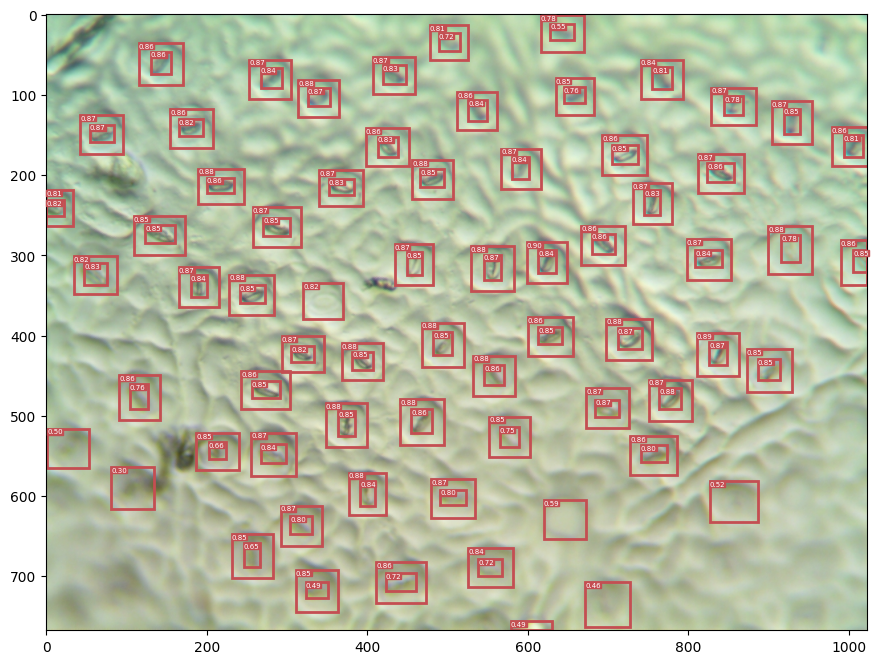

In [22]:
image_path = "datasets/val/images/STMHD0007.jpg"

results = modelAdjust.predict(image_path)[0]

plot_detections(results)

## Entrenamiento 1-plantOut

In [ ]:
species = metadata.Species.unique()
for s in species:
    modelSimple = YOLO('Modelos\yolov10\yolov10n.pt')
    # Ordenamos por cada planta
    onePlantOut(s)
    modelSimple.train(data='YOLO8INFO.yaml', epochs=30, imgsz=640, batch= 16, device=0) 
    modelSimple.save(f'Modelos\yolov10\{s}SimpleYolov10n.pt')

New https://pypi.org/project/ultralytics/8.3.9 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: task=detect, mode=train, model=Modelos\yolov8\yolov8n.pt, data=YOLO8INFO.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=

train: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\train\labels.cache... 10630 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10630/10630 [00:00<?, ?it/s]
val: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\labels.cache... 85 images, 0 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<?, ?it/s]


Plotting labels to runs\detect\train12\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train12
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      12.2G      1.115     0.9878     0.9331        946        640: 100%|██████████| 665/665 [02:20<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]

                   all         85       1856      0.905      0.935      0.966      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      11.8G     0.9222     0.5336     0.8738        786        640: 100%|██████████| 665/665 [02:13<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

                   all         85       1856      0.944      0.939      0.972      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      8.28G     0.8892     0.4923     0.8674        732        640: 100%|██████████| 665/665 [02:10<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

                   all         85       1856      0.938      0.917       0.97      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      12.4G     0.8703      0.467      0.863       1017        640: 100%|██████████| 665/665 [02:12<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]

                   all         85       1856      0.965      0.934      0.977      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      10.2G     0.8501       0.45     0.8592       1223        640: 100%|██████████| 665/665 [02:09<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.21it/s]

                   all         85       1856      0.934      0.949      0.976      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      7.69G     0.8328     0.4367     0.8553        550        640: 100%|██████████| 665/665 [02:11<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.17it/s]

                   all         85       1856      0.963      0.941      0.979      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      11.6G     0.8277     0.4299     0.8544        570        640: 100%|██████████| 665/665 [02:09<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]

                   all         85       1856      0.969      0.942       0.98      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      11.9G     0.8167     0.4218     0.8524        767        640: 100%|██████████| 665/665 [02:16<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.32it/s]

                   all         85       1856      0.961      0.938      0.981      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      8.24G     0.8082     0.4152     0.8509        890        640: 100%|██████████| 665/665 [02:04<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.26it/s]

                   all         85       1856      0.973      0.934      0.982      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30        10G     0.7991     0.4082     0.8494       1022        640: 100%|██████████| 665/665 [02:05<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.49it/s]

                   all         85       1856      0.963      0.951      0.983      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      16.4G     0.7918     0.4037     0.8479        589        640: 100%|██████████| 665/665 [02:24<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.45it/s]

                   all         85       1856      0.975      0.945      0.982      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      13.9G     0.7867     0.4001     0.8473        969        640: 100%|██████████| 665/665 [02:13<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.24it/s]

                   all         85       1856      0.969       0.95      0.983      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      10.8G     0.7811     0.3944     0.8458       1040        640: 100%|██████████| 665/665 [02:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.36it/s]

                   all         85       1856      0.971      0.941      0.982      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      8.13G     0.7757     0.3911     0.8455        682        640: 100%|██████████| 665/665 [02:03<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         85       1856      0.958      0.952      0.984       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      10.6G     0.7687     0.3861     0.8438        794        640: 100%|██████████| 665/665 [02:04<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.54it/s]

                   all         85       1856      0.964      0.944      0.986      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      8.03G     0.7652      0.384     0.8437        858        640: 100%|██████████| 665/665 [02:02<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]

                   all         85       1856      0.965      0.945      0.986      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      11.8G     0.7622     0.3808     0.8431        813        640: 100%|██████████| 665/665 [02:03<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.49it/s]

                   all         85       1856       0.96      0.944      0.985      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      8.11G     0.7545     0.3762      0.842        743        640: 100%|██████████| 665/665 [02:02<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]

                   all         85       1856      0.966      0.947      0.986      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      10.6G     0.7532     0.3738     0.8418        838        640: 100%|██████████| 665/665 [02:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.53it/s]

                   all         85       1856      0.963      0.944      0.984      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      14.3G     0.7494     0.3707     0.8405        617        640: 100%|██████████| 665/665 [02:34<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.29it/s]

                   all         85       1856       0.96      0.955      0.987      0.801


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      6.69G     0.7324     0.3568     0.8403        450        640: 100%|██████████| 665/665 [01:51<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]

                   all         85       1856      0.964      0.953      0.986      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      6.93G     0.7204       0.35     0.8372        639        640: 100%|██████████| 665/665 [01:50<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.84it/s]

                   all         85       1856       0.96      0.956      0.985        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      7.19G      0.716     0.3462     0.8366        423        640: 100%|██████████| 665/665 [01:51<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]

                   all         85       1856       0.96       0.95      0.987      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      7.52G     0.7106     0.3422     0.8356        563        640: 100%|██████████| 665/665 [01:50<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.56it/s]

                   all         85       1856      0.975      0.948      0.987      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      6.13G     0.7054     0.3377     0.8355        416        640: 100%|██████████| 665/665 [01:50<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.81it/s]

                   all         85       1856      0.957      0.956      0.987      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      7.31G     0.7002      0.335     0.8343        506        640: 100%|██████████| 665/665 [01:51<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]

                   all         85       1856      0.966      0.955      0.988      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.35G     0.6965     0.3322      0.833        561        640: 100%|██████████| 665/665 [01:50<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.47it/s]

                   all         85       1856      0.958      0.963      0.988      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.52G     0.6917     0.3284     0.8324        532        640: 100%|██████████| 665/665 [01:51<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.41it/s]

                   all         85       1856      0.973      0.939      0.987      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      7.34G     0.6866     0.3254     0.8315        512        640: 100%|██████████| 665/665 [01:51<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.45it/s]

                   all         85       1856      0.955      0.962      0.987      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.99G     0.6821     0.3215     0.8313        663        640: 100%|██████████| 665/665 [02:00<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]

                   all         85       1856      0.961      0.957      0.988      0.812



30 epochs completed in 1.054 hours.
Optimizer stripped from runs\detect\train12\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train12\weights\best.pt, 6.2MB

Validating runs\detect\train12\weights\best.pt...
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


                   all         85       1856      0.961      0.956      0.988      0.813
                stoma1         85       1074      0.961      0.962       0.99      0.819
                stoma2         85        782      0.961       0.95      0.986      0.806
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\train12
New https://pypi.org/project/ultralytics/8.3.9 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: task=detect, mode=train, model=Modelos\yolov8\yolov8n.pt, data=YOLO8INFO.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train13, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=Tru

train: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\train\labels... 10585 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10585/10585 [00:07<00:00, 1380.17it/s]


train: New cache created: C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\train\labels.cache


val: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\labels... 130 images, 0 backgrounds, 0 corrupt: 100%|██████████| 130/130 [00:00<00:00, 1214.71it/s]

val: New cache created: C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\labels.cache


Plotting labels to runs\detect\train13\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train13
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      7.94G      1.115     0.9909     0.9322        927        640: 100%|██████████| 662/662 [02:25<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.56it/s]

                   all        130       3128      0.796      0.797      0.846      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      8.47G     0.9218     0.5326      0.874        722        640: 100%|██████████| 662/662 [02:14<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]

                   all        130       3128      0.787      0.809      0.842      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      12.2G     0.8922     0.4923     0.8676        753        640: 100%|██████████| 662/662 [02:15<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.31it/s]

                   all        130       3128      0.815      0.857      0.871      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      9.62G     0.8718     0.4692     0.8627       1155        640: 100%|██████████| 662/662 [02:11<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]

                   all        130       3128      0.814      0.815      0.853      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      10.1G      0.851     0.4527     0.8591       1490        640: 100%|██████████| 662/662 [02:06<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.73it/s]

                   all        130       3128      0.804      0.868      0.893      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      11.4G     0.8329     0.4363     0.8556       1109        640: 100%|██████████| 662/662 [02:02<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.03it/s]

                   all        130       3128      0.833      0.884      0.895      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      10.7G     0.8247     0.4295     0.8539       1292        640: 100%|██████████| 662/662 [02:03<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.85it/s]

                   all        130       3128      0.847      0.854      0.907      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      7.96G     0.8145     0.4191     0.8522        949        640: 100%|██████████| 662/662 [02:02<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.88it/s]

                   all        130       3128      0.839      0.843        0.9       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      10.3G     0.8078      0.415     0.8509        761        640: 100%|██████████| 662/662 [02:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.08it/s]

                   all        130       3128      0.849      0.836      0.893      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      9.11G     0.7972     0.4066      0.849       2052        640: 100%|██████████| 662/662 [02:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.13it/s]

                   all        130       3128      0.854      0.868      0.909      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      9.72G     0.7957     0.4049     0.8483        969        640: 100%|██████████| 662/662 [02:04<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.89it/s]

                   all        130       3128      0.817      0.873      0.906      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30       9.2G     0.7902     0.3994      0.848       1396        640: 100%|██████████| 662/662 [02:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.73it/s]

                   all        130       3128      0.825      0.864      0.899      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      12.1G     0.7818     0.3948     0.8465        947        640: 100%|██████████| 662/662 [02:15<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.75it/s]

                   all        130       3128       0.88      0.837      0.923      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      11.4G     0.7772     0.3906      0.846        506        640: 100%|██████████| 662/662 [02:06<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.98it/s]

                   all        130       3128      0.863       0.84      0.915      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      9.29G     0.7719     0.3883     0.8447       1155        640: 100%|██████████| 662/662 [02:04<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.86it/s]

                   all        130       3128      0.855      0.865      0.918      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      10.7G     0.7654     0.3831      0.844        984        640: 100%|██████████| 662/662 [02:04<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.86it/s]

                   all        130       3128      0.849       0.86      0.913      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30        10G     0.7616     0.3808     0.8428       1213        640: 100%|██████████| 662/662 [02:04<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.59it/s]

                   all        130       3128      0.861      0.861      0.916      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      13.7G     0.7555     0.3766     0.8422        932        640: 100%|██████████| 662/662 [02:11<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.76it/s]

                   all        130       3128      0.846      0.877      0.919        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30        11G     0.7546     0.3748     0.8421        935        640: 100%|██████████| 662/662 [02:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.94it/s]

                   all        130       3128      0.822        0.9      0.919      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      11.9G     0.7526     0.3724     0.8412       1068        640: 100%|██████████| 662/662 [02:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.90it/s]

                   all        130       3128      0.861      0.874      0.924      0.707


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      8.43G     0.7317     0.3583     0.8396        563        640: 100%|██████████| 662/662 [01:52<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.91it/s]

                   all        130       3128      0.837      0.873      0.902      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30       8.9G     0.7192     0.3496     0.8371        654        640: 100%|██████████| 662/662 [01:50<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.02it/s]

                   all        130       3128      0.867      0.853      0.921      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.61G     0.7154     0.3453     0.8363        643        640: 100%|██████████| 662/662 [01:49<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.96it/s]

                   all        130       3128      0.833      0.903      0.925      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.96G      0.712     0.3431     0.8363        401        640: 100%|██████████| 662/662 [01:52<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.65it/s]

                   all        130       3128      0.825      0.899       0.92      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.45G     0.7055      0.339     0.8348        575        640: 100%|██████████| 662/662 [01:51<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.15it/s]

                   all        130       3128      0.844      0.869       0.92       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      5.22G        0.7     0.3345     0.8344        758        640: 100%|██████████| 662/662 [01:51<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.87it/s]

                   all        130       3128      0.837      0.888      0.927      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.82G     0.6946     0.3314     0.8334        668        640: 100%|██████████| 662/662 [01:50<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.10it/s]

                   all        130       3128      0.825      0.892      0.926      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.42G     0.6909     0.3282     0.8327        733        640: 100%|██████████| 662/662 [01:50<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.01it/s]

                   all        130       3128      0.876      0.864      0.926      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30       8.7G     0.6875     0.3253     0.8321        799        640: 100%|██████████| 662/662 [01:50<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.07it/s]

                   all        130       3128      0.885       0.85      0.927      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.48G     0.6826     0.3222     0.8309        571        640: 100%|██████████| 662/662 [01:50<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.10it/s]

                   all        130       3128      0.888      0.853      0.927      0.723



30 epochs completed in 1.039 hours.
Optimizer stripped from runs\detect\train13\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train13\weights\best.pt, 6.2MB

Validating runs\detect\train13\weights\best.pt...
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


                   all        130       3128      0.874      0.863      0.926      0.729
                stoma1        130       2792       0.96      0.947      0.988      0.812
                stoma2        122        336      0.788       0.78      0.864      0.647
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train13
New https://pypi.org/project/ultralytics/8.3.9 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: task=detect, mode=train, model=Modelos\yolov8\yolov8n.pt, data=YOLO8INFO.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train14, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=Tru

train: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\train\labels... 10615 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10615/10615 [00:10<00:00, 979.94it/s] 


train: New cache created: C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\train\labels.cache


val: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 558.49it/s]

val: New cache created: C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\labels.cache


Plotting labels to runs\detect\train14\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train14
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      13.5G      1.117     0.9929     0.9336        993        640: 100%|██████████| 664/664 [02:16<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.01it/s]

                   all        100       2586       0.91      0.919      0.961      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      7.13G     0.9221     0.5323     0.8731        737        640: 100%|██████████| 664/664 [02:05<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.93it/s]

                   all        100       2586      0.924      0.923      0.963        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      8.13G      0.891     0.4926     0.8675        828        640: 100%|██████████| 664/664 [02:03<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.89it/s]

                   all        100       2586      0.943      0.914      0.971      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      12.8G     0.8719     0.4687     0.8632        990        640: 100%|██████████| 664/664 [02:07<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.89it/s]

                   all        100       2586      0.935      0.908      0.963       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      7.24G     0.8505     0.4507      0.859        982        640: 100%|██████████| 664/664 [02:03<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.67it/s]

                   all        100       2586      0.932      0.923      0.971      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      13.8G     0.8405     0.4413      0.857        696        640: 100%|██████████| 664/664 [02:09<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.96it/s]

                   all        100       2586      0.907       0.93      0.965      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      10.5G     0.8215     0.4275      0.853       1035        640: 100%|██████████| 664/664 [02:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.11it/s]

                   all        100       2586      0.937      0.934      0.977       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      14.6G     0.8146     0.4208     0.8521       1239        640: 100%|██████████| 664/664 [02:09<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]

                   all        100       2586      0.936      0.947      0.977      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      9.65G     0.8049     0.4122     0.8503        679        640: 100%|██████████| 664/664 [02:03<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.00it/s]

                   all        100       2586      0.939       0.94      0.979      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      9.58G     0.7976     0.4069     0.8497        848        640: 100%|██████████| 664/664 [02:03<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.90it/s]

                   all        100       2586      0.923      0.947      0.974      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      9.53G     0.7895     0.4013     0.8471        526        640: 100%|██████████| 664/664 [02:04<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.10it/s]

                   all        100       2586      0.928      0.938      0.975      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      11.8G      0.785     0.3985      0.847        948        640: 100%|██████████| 664/664 [02:03<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]

                   all        100       2586      0.922      0.938      0.972      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      9.92G     0.7799     0.3939      0.846        763        640: 100%|██████████| 664/664 [02:02<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]

                   all        100       2586      0.936      0.938      0.981      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30        14G     0.7776     0.3906     0.8466        405        640: 100%|██████████| 664/664 [02:14<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.72it/s]

                   all        100       2586      0.926      0.952      0.978      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30        13G     0.7717     0.3868     0.8446       1065        640: 100%|██████████| 664/664 [06:00<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        100       2586      0.913      0.953      0.976      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      11.4G     0.7656     0.3827     0.8436       1073        640: 100%|██████████| 664/664 [02:02<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.06it/s]

                   all        100       2586      0.938      0.941      0.978      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      11.6G     0.7618     0.3799     0.8426        648        640: 100%|██████████| 664/664 [02:03<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]

                   all        100       2586      0.941      0.936      0.978      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      16.4G     0.7575      0.377     0.8424        644        640: 100%|██████████| 664/664 [02:31<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.05it/s]

                   all        100       2586       0.93      0.945      0.978      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      12.2G      0.753     0.3738     0.8419        985        640: 100%|██████████| 664/664 [02:05<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

                   all        100       2586      0.934      0.953      0.979      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      14.7G     0.7478     0.3701     0.8404        771        640: 100%|██████████| 664/664 [02:10<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.99it/s]

                   all        100       2586      0.934      0.949      0.979      0.764


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30       7.7G     0.7344     0.3585     0.8394        617        640: 100%|██████████| 664/664 [01:53<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.62it/s]

                   all        100       2586      0.937      0.937       0.98      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.66G     0.7204     0.3504     0.8377        349        640: 100%|██████████| 664/664 [01:51<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.98it/s]

                   all        100       2586      0.951      0.931      0.981      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.51G     0.7165     0.3468     0.8368        385        640: 100%|██████████| 664/664 [01:51<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.17it/s]

                   all        100       2586      0.927      0.954      0.979      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      5.06G     0.7092     0.3416     0.8357        400        640: 100%|██████████| 664/664 [01:50<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.95it/s]

                   all        100       2586      0.933      0.951      0.979       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      6.87G      0.705     0.3382     0.8346        418        640: 100%|██████████| 664/664 [01:51<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.16it/s]

                   all        100       2586      0.929       0.95      0.979      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      5.14G     0.7014     0.3353     0.8343        488        640: 100%|██████████| 664/664 [01:51<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]

                   all        100       2586      0.936       0.95      0.982      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.71G     0.6948     0.3307     0.8335        735        640: 100%|██████████| 664/664 [01:51<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.89it/s]

                   all        100       2586      0.933      0.953      0.982      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.28G     0.6922     0.3284     0.8323        580        640: 100%|██████████| 664/664 [01:51<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.05it/s]

                   all        100       2586      0.936      0.954      0.982      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30         8G     0.6862     0.3243     0.8322        381        640: 100%|██████████| 664/664 [01:52<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.89it/s]

                   all        100       2586      0.929      0.958      0.982      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.34G     0.6837     0.3223     0.8313        425        640: 100%|██████████| 664/664 [01:51<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.02it/s]

                   all        100       2586      0.947      0.939      0.982      0.777



30 epochs completed in 1.104 hours.
Optimizer stripped from runs\detect\train14\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train14\weights\best.pt, 6.2MB

Validating runs\detect\train14\weights\best.pt...
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]


                   all        100       2586      0.942      0.946      0.982      0.777
                stoma1        100       1759      0.982       0.96      0.993      0.806
                stoma2        100        827      0.902      0.931      0.971      0.748
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train14
New https://pypi.org/project/ultralytics/8.3.9 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: task=detect, mode=train, model=Modelos\yolov8\yolov8n.pt, data=YOLO8INFO.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train15, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=Tru

train: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\train\labels... 10519 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10519/10519 [00:05<00:00, 1972.00it/s]


train: New cache created: C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\train\labels.cache


val: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\labels... 196 images, 0 backgrounds, 0 corrupt: 100%|██████████| 196/196 [00:00<00:00, 1224.62it/s]

val: New cache created: C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\labels.cache


Plotting labels to runs\detect\train15\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train15
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      11.5G      1.125     0.9972     0.9324        715        640: 100%|██████████| 658/658 [02:10<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]

                   all        196      13406      0.912      0.946      0.971      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      7.28G      0.921     0.5331     0.8729        724        640: 100%|██████████| 658/658 [02:05<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.65it/s]

                   all        196      13406      0.927       0.96      0.974      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      12.5G     0.8955     0.4913     0.8677        732        640: 100%|██████████| 658/658 [02:05<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.46it/s]

                   all        196      13406      0.935      0.959      0.979      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      12.1G     0.8719     0.4715     0.8631        439        640: 100%|██████████| 658/658 [02:04<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]

                   all        196      13406      0.938      0.959      0.979      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      17.7G     0.8532     0.4537     0.8587       1274        640: 100%|██████████| 658/658 [02:27<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.63it/s]

                   all        196      13406       0.93      0.963      0.981      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      7.78G     0.8392     0.4399     0.8561        649        640: 100%|██████████| 658/658 [02:10<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]

                   all        196      13406      0.943      0.958      0.982      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30       7.7G     0.8239      0.429      0.853       1221        640: 100%|██████████| 658/658 [02:04<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.75it/s]

                   all        196      13406      0.947       0.96      0.982      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      13.2G     0.8197     0.4232     0.8526        405        640: 100%|██████████| 658/658 [02:07<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]

                   all        196      13406      0.943       0.96      0.983      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30       9.7G     0.8097      0.417     0.8511        859        640: 100%|██████████| 658/658 [02:02<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]

                   all        196      13406      0.946      0.961      0.985      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      6.37G     0.7994     0.4092     0.8486        662        640: 100%|██████████| 658/658 [02:02<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]

                   all        196      13406      0.948      0.965      0.985      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      10.8G     0.7952     0.4029     0.8476        954        640: 100%|██████████| 658/658 [02:03<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.88it/s]

                   all        196      13406      0.949      0.963      0.986      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30        12G     0.7849     0.3989     0.8461        639        640: 100%|██████████| 658/658 [02:03<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]

                   all        196      13406      0.939      0.968      0.984      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      12.4G     0.7855     0.3958     0.8461       1261        640: 100%|██████████| 658/658 [02:05<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.83it/s]

                   all        196      13406      0.948      0.963      0.985      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      11.6G     0.7795     0.3926     0.8452        528        640: 100%|██████████| 658/658 [02:03<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.81it/s]

                   all        196      13406      0.946      0.964      0.984      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      14.7G     0.7745     0.3893     0.8443        865        640: 100%|██████████| 658/658 [02:26<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.01it/s]

                   all        196      13406      0.947      0.963      0.985      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      12.1G     0.7695      0.386     0.8443        959        640: 100%|██████████| 658/658 [02:04<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]

                   all        196      13406       0.95      0.961      0.985      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      11.8G     0.7659     0.3817     0.8427        667        640: 100%|██████████| 658/658 [02:04<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]

                   all        196      13406      0.945      0.968      0.986      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      9.77G     0.7592     0.3792     0.8424       1418        640: 100%|██████████| 658/658 [02:03<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.76it/s]

                   all        196      13406       0.95      0.963      0.986      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      8.25G     0.7567     0.3764     0.8421        843        640: 100%|██████████| 658/658 [02:03<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.56it/s]

                   all        196      13406      0.932      0.971      0.984      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      8.14G     0.7527     0.3731     0.8412        941        640: 100%|██████████| 658/658 [02:03<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.79it/s]

                   all        196      13406      0.952      0.962      0.986       0.83


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      6.17G     0.7345     0.3585     0.8396        806        640: 100%|██████████| 658/658 [01:50<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.85it/s]

                   all        196      13406      0.941      0.969      0.985      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      7.79G     0.7234     0.3511     0.8378        682        640: 100%|██████████| 658/658 [01:49<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.96it/s]

                   all        196      13406      0.943      0.969      0.986      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30       4.8G     0.7172     0.3479      0.837        287        640: 100%|██████████| 658/658 [01:49<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.96it/s]

                   all        196      13406      0.944       0.97      0.986      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.75G     0.7134     0.3437     0.8359        343        640: 100%|██████████| 658/658 [01:49<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.91it/s]

                   all        196      13406       0.94      0.971      0.986      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      5.97G     0.7058     0.3393     0.8348        371        640: 100%|██████████| 658/658 [01:49<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.73it/s]

                   all        196      13406      0.956      0.958      0.987      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.41G     0.7024      0.336     0.8347        506        640: 100%|██████████| 658/658 [01:49<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.00it/s]

                   all        196      13406      0.942       0.97      0.986       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.75G      0.697     0.3319     0.8341        340        640: 100%|██████████| 658/658 [01:49<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.90it/s]

                   all        196      13406      0.952      0.968      0.987      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.05G     0.6951       0.33     0.8325        395        640: 100%|██████████| 658/658 [01:49<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.88it/s]

                   all        196      13406      0.953      0.964      0.987      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      7.38G     0.6882      0.326     0.8322        279        640: 100%|██████████| 658/658 [01:49<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.91it/s]

                   all        196      13406      0.951      0.967      0.987      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      7.16G     0.6859     0.3235     0.8304        850        640: 100%|██████████| 658/658 [01:49<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.90it/s]

                   all        196      13406      0.952      0.965      0.987      0.845



30 epochs completed in 1.038 hours.
Optimizer stripped from runs\detect\train15\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train15\weights\best.pt, 6.2MB

Validating runs\detect\train15\weights\best.pt...
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


                   all        196      13406      0.952      0.967      0.987      0.846
                stoma1        196       7868       0.99       0.98      0.994      0.882
                stoma2        196       5538      0.914      0.954      0.979       0.81
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\train15
New https://pypi.org/project/ultralytics/8.3.9 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: task=detect, mode=train, model=Modelos\yolov8\yolov8n.pt, data=YOLO8INFO.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train16, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=Tru

train: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\train\labels... 10665 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10665/10665 [00:05<00:00, 1924.50it/s]


train: New cache created: C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\train\labels.cache


val: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\labels... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 1515.15it/s]

val: New cache created: C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\labels.cache


Plotting labels to runs\detect\train16\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train16
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      10.9G      1.112     0.9875     0.9324       1283        640: 100%|██████████| 667/667 [02:13<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

                   all         50        600      0.638      0.795      0.701      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      8.56G     0.9213     0.5342     0.8733       1059        640: 100%|██████████| 667/667 [02:06<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

                   all         50        600      0.623      0.712      0.656      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      10.3G      0.895     0.4916     0.8682       1323        640: 100%|██████████| 667/667 [02:04<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

                   all         50        600      0.705      0.741      0.709      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      8.15G     0.8774     0.4749     0.8643        837        640: 100%|██████████| 667/667 [02:03<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.16it/s]

                   all         50        600      0.708      0.829      0.729      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      11.9G     0.8526     0.4496     0.8593        913        640: 100%|██████████| 667/667 [02:04<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

                   all         50        600      0.727      0.847      0.779      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      11.4G      0.836     0.4376     0.8564        775        640: 100%|██████████| 667/667 [02:04<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]

                   all         50        600      0.725      0.859      0.773      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      11.9G     0.8241     0.4285     0.8533       1519        640: 100%|██████████| 667/667 [02:06<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

                   all         50        600      0.684      0.906      0.795      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      11.6G     0.8156     0.4216     0.8518       1011        640: 100%|██████████| 667/667 [02:04<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

                   all         50        600      0.727      0.814      0.755      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      11.6G     0.8071     0.4144     0.8508       1227        640: 100%|██████████| 667/667 [02:03<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

                   all         50        600      0.738      0.851      0.788      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      9.21G     0.7986     0.4063     0.8492       1211        640: 100%|██████████| 667/667 [02:03<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

                   all         50        600       0.74      0.843      0.788      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30       9.5G     0.7904     0.4026     0.8477        952        640: 100%|██████████| 667/667 [02:03<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         50        600      0.747      0.849        0.8      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      13.1G     0.7874      0.399     0.8471       1057        640: 100%|██████████| 667/667 [02:09<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.94it/s]

                   all         50        600       0.75      0.846      0.802      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      10.6G     0.7811     0.3937     0.8461        901        640: 100%|██████████| 667/667 [02:04<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

                   all         50        600      0.724      0.882      0.784      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      14.9G     0.7738     0.3904     0.8456       1023        640: 100%|██████████| 667/667 [02:13<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

                   all         50        600      0.726      0.853      0.797      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      11.5G     0.7706     0.3872     0.8449       1260        640: 100%|██████████| 667/667 [02:04<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         50        600      0.727       0.88      0.786      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30        14G     0.7666     0.3833     0.8437        915        640: 100%|██████████| 667/667 [02:09<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.22it/s]

                   all         50        600      0.725      0.851      0.788      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      9.76G     0.7633     0.3804     0.8432        770        640: 100%|██████████| 667/667 [02:04<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.94it/s]

                   all         50        600      0.732      0.851      0.783      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      15.3G     0.7554      0.376     0.8419        964        640: 100%|██████████| 667/667 [02:20<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

                   all         50        600      0.738      0.865      0.806       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      10.3G     0.7545     0.3751     0.8419       1020        640: 100%|██████████| 667/667 [02:05<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

                   all         50        600      0.751      0.856       0.79      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      11.7G     0.7478     0.3711     0.8404       1463        640: 100%|██████████| 667/667 [02:05<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.05it/s]

                   all         50        600      0.751      0.876      0.802      0.566


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      7.46G     0.7301     0.3561      0.839        461        640: 100%|██████████| 667/667 [01:53<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

                   all         50        600       0.74      0.854      0.811      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.72G     0.7207     0.3497     0.8377        642        640: 100%|██████████| 667/667 [01:51<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]

                   all         50        600      0.771        0.8      0.803      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.47G     0.7154      0.346     0.8367        501        640: 100%|██████████| 667/667 [01:51<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

                   all         50        600      0.749      0.878      0.813      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      7.38G     0.7101     0.3421     0.8359        474        640: 100%|██████████| 667/667 [01:52<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.16it/s]

                   all         50        600      0.772      0.818      0.808      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      7.52G     0.7041      0.338     0.8348        817        640: 100%|██████████| 667/667 [01:51<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.04it/s]

                   all         50        600      0.743       0.86      0.813      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.68G     0.7011      0.335     0.8344        771        640: 100%|██████████| 667/667 [01:51<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

                   all         50        600       0.73       0.88      0.813      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30       5.4G      0.695     0.3314     0.8329        559        640: 100%|██████████| 667/667 [01:51<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

                   all         50        600      0.724       0.88      0.811      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      7.05G     0.6923     0.3283     0.8324        843        640: 100%|██████████| 667/667 [01:51<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

                   all         50        600      0.749      0.875      0.816      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      6.49G     0.6862     0.3248     0.8309        752        640: 100%|██████████| 667/667 [01:51<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

                   all         50        600      0.738       0.89      0.817      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.05G     0.6824     0.3222     0.8312        758        640: 100%|██████████| 667/667 [01:51<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.94it/s]

                   all         50        600      0.729      0.874       0.82      0.608



30 epochs completed in 1.033 hours.
Optimizer stripped from runs\detect\train16\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train16\weights\best.pt, 6.2MB

Validating runs\detect\train16\weights\best.pt...
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


                   all         50        600      0.731      0.874       0.82      0.608
                stoma1         50        500      0.935      0.958      0.979      0.747
                stoma2         43        100      0.527       0.79      0.662      0.469
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\detect\train16
New https://pypi.org/project/ultralytics/8.3.9 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: task=detect, mode=train, model=Modelos\yolov8\yolov8n.pt, data=YOLO8INFO.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train17, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=Tru

train: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\train\labels... 10633 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10633/10633 [00:05<00:00, 1965.99it/s]


train: New cache created: C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\train\labels.cache


val: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\labels... 82 images, 0 backgrounds, 0 corrupt: 100%|██████████| 82/82 [00:00<00:00, 1490.55it/s]

val: New cache created: C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\labels.cache


Plotting labels to runs\detect\train17\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train17
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      6.67G      1.108     0.9865     0.9316        842        640: 100%|██████████| 665/665 [02:11<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.77it/s]

                   all         82       1217      0.468      0.624      0.551      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      12.2G     0.9241     0.5329     0.8742        650        640: 100%|██████████| 665/665 [02:06<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.55it/s]

                   all         82       1217      0.583      0.526      0.551      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      7.39G     0.8952      0.494     0.8682       1122        640: 100%|██████████| 665/665 [02:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.63it/s]

                   all         82       1217      0.688      0.605      0.584      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       8.9G     0.8698     0.4695     0.8626       1062        640: 100%|██████████| 665/665 [02:02<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.87it/s]

                   all         82       1217      0.571      0.622      0.553      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30        14G     0.8452     0.4494     0.8581       1971        640: 100%|██████████| 665/665 [02:46<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all         82       1217      0.497      0.714      0.518      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      12.8G     0.8362     0.4388      0.856        637        640: 100%|██████████| 665/665 [02:16<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.18it/s]

                   all         82       1217      0.548      0.572      0.567      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      12.1G     0.8299     0.4315     0.8545        836        640: 100%|██████████| 665/665 [02:14<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.57it/s]

                   all         82       1217      0.559      0.623       0.54      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      7.48G     0.8153     0.4202     0.8519        909        640: 100%|██████████| 665/665 [02:13<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.32it/s]

                   all         82       1217      0.533      0.623       0.54       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      11.1G     0.8056     0.4139     0.8508       1940        640: 100%|██████████| 665/665 [02:13<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all         82       1217      0.543       0.67      0.548      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      9.85G      0.802     0.4096       0.85        904        640: 100%|██████████| 665/665 [02:13<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]

                   all         82       1217      0.521      0.764      0.542       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      10.8G     0.7887     0.4006     0.8471        874        640: 100%|██████████| 665/665 [02:13<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]

                   all         82       1217      0.492      0.671      0.518      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      14.4G      0.785     0.3986     0.8472       1184        640: 100%|██████████| 665/665 [02:11<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.90it/s]

                   all         82       1217      0.559      0.573      0.527      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30        12G     0.7818      0.394     0.8461       1413        640: 100%|██████████| 665/665 [02:20<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all         82       1217      0.515      0.668      0.518      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      10.3G     0.7749     0.3903      0.846       1164        640: 100%|██████████| 665/665 [02:03<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.63it/s]

                   all         82       1217      0.526      0.621      0.526      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      8.94G     0.7693     0.3873     0.8439       1503        640: 100%|██████████| 665/665 [02:05<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.87it/s]

                   all         82       1217      0.503      0.675      0.545       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      8.81G     0.7654     0.3838      0.844        889        640: 100%|██████████| 665/665 [02:03<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]

                   all         82       1217      0.553      0.666      0.536      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      12.6G     0.7636     0.3817     0.8435       1146        640: 100%|██████████| 665/665 [02:08<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.85it/s]

                   all         82       1217      0.605      0.525       0.53      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      10.8G      0.755     0.3774     0.8419       1125        640: 100%|██████████| 665/665 [02:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.71it/s]

                   all         82       1217       0.51      0.581      0.526      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      9.92G     0.7538     0.3747      0.842        785        640: 100%|██████████| 665/665 [02:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.83it/s]

                   all         82       1217      0.533      0.626       0.53       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      13.1G     0.7499     0.3723     0.8408        980        640: 100%|██████████| 665/665 [02:09<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.77it/s]

                   all         82       1217      0.563      0.625      0.538       0.39


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      9.46G     0.7289     0.3558     0.8392        505        640: 100%|██████████| 665/665 [01:53<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.70it/s]

                   all         82       1217      0.562      0.531      0.525      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.98G     0.7213     0.3505      0.837        665        640: 100%|██████████| 665/665 [01:51<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]

                   all         82       1217      0.556      0.672       0.54      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      6.14G     0.7149     0.3459     0.8368        576        640: 100%|██████████| 665/665 [01:51<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.63it/s]

                   all         82       1217      0.539      0.627      0.553      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.18G     0.7079      0.341     0.8359        524        640: 100%|██████████| 665/665 [01:51<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.79it/s]

                   all         82       1217      0.529      0.628      0.535      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      5.39G     0.7043     0.3383     0.8346        530        640: 100%|██████████| 665/665 [01:51<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.80it/s]

                   all         82       1217      0.592      0.672       0.56      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.26G     0.6995     0.3349      0.834        470        640: 100%|██████████| 665/665 [01:51<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]

                   all         82       1217      0.573      0.622      0.548      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.77G     0.6945     0.3317     0.8335        640        640: 100%|██████████| 665/665 [01:51<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]

                   all         82       1217      0.557      0.673      0.544      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30       5.6G     0.6905     0.3281     0.8327        505        640: 100%|██████████| 665/665 [01:51<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.76it/s]

                   all         82       1217      0.552      0.624      0.544      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30        10G     0.6856     0.3243     0.8314        608        640: 100%|██████████| 665/665 [01:51<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.84it/s]

                   all         82       1217      0.594      0.622      0.555        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.43G     0.6829     0.3221      0.831        597        640: 100%|██████████| 665/665 [01:51<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.58it/s]

                   all         82       1217      0.585      0.624      0.547      0.397



30 epochs completed in 1.057 hours.
Optimizer stripped from runs\detect\train17\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train17\weights\best.pt, 6.2MB

Validating runs\detect\train17\weights\best.pt...
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


                   all         82       1217       0.54      0.627      0.553      0.403
                stoma1         82       1206      0.935      0.981       0.99      0.735
                stoma2         11         11      0.144      0.273      0.117     0.0705
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\train17
New https://pypi.org/project/ultralytics/8.3.9 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: task=detect, mode=train, model=Modelos\yolov8\yolov8n.pt, data=YOLO8INFO.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train18, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=Tru

train: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\train\labels... 7647 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7647/7647 [00:04<00:00, 1756.54it/s]


train: New cache created: C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\train\labels.cache


val: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\labels... 3068 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3068/3068 [00:02<00:00, 1478.52it/s]


val: New cache created: C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\labels.cache
Plotting labels to runs\detect\train18\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train18
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      11.9G      1.104      1.056     0.9366       2461        640: 100%|██████████| 478/478 [01:39<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [00:26<00:00,  3.63it/s]


                   all       3068      98962      0.531      0.577      0.528      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      11.8G     0.9007     0.5284     0.8711       2422        640: 100%|██████████| 478/478 [01:34<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [00:26<00:00,  3.63it/s]


                   all       3068      98962      0.524      0.594       0.53      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30        12G     0.8689     0.4901     0.8644       2471        640: 100%|██████████| 478/478 [01:33<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [00:26<00:00,  3.64it/s]


                   all       3068      98962      0.555      0.655      0.573      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      8.21G     0.8417     0.4621     0.8588       2317        640: 100%|██████████| 478/478 [01:31<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [00:25<00:00,  3.70it/s]


                   all       3068      98962      0.561      0.647      0.569      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      8.92G     0.8271     0.4441     0.8562       2425        640: 100%|██████████| 478/478 [01:31<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [00:25<00:00,  3.72it/s]


                   all       3068      98962      0.621      0.637      0.623      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      10.2G     0.8118     0.4335     0.8535       2183        640: 100%|██████████| 478/478 [01:31<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [00:25<00:00,  3.75it/s]


                   all       3068      98962      0.615      0.662      0.626      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      12.9G     0.8014     0.4259     0.8515       2389        640: 100%|██████████| 478/478 [01:36<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [00:25<00:00,  3.74it/s]


                   all       3068      98962      0.582      0.653      0.588      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      13.3G     0.7948     0.4188     0.8496       2410        640: 100%|██████████| 478/478 [03:41<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [00:58<00:00,  1.65it/s]


                   all       3068      98962      0.603      0.643      0.612      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      12.7G     0.7835     0.4088     0.8478       2460        640: 100%|██████████| 478/478 [01:32<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [00:26<00:00,  3.61it/s]


                   all       3068      98962      0.602      0.663      0.617       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      11.1G     0.7726     0.4009     0.8462       1958        640: 100%|██████████| 478/478 [01:31<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [00:25<00:00,  3.82it/s]


                   all       3068      98962      0.604      0.633      0.609      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      15.4G     0.7658     0.3947     0.8442       2640        640: 100%|██████████| 478/478 [01:56<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [00:25<00:00,  3.74it/s]


                   all       3068      98962      0.599      0.654      0.608      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      11.2G     0.7608     0.3909     0.8433       2497        640: 100%|██████████| 478/478 [01:33<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [00:27<00:00,  3.48it/s]


                   all       3068      98962      0.628      0.658      0.636      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      11.4G     0.7569     0.3875     0.8433       3157        640: 100%|██████████| 478/478 [01:32<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [00:27<00:00,  3.44it/s]


                   all       3068      98962      0.607      0.652      0.622      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      12.2G      0.747     0.3808     0.8415       2176        640: 100%|██████████| 478/478 [01:35<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [00:27<00:00,  3.45it/s]


                   all       3068      98962      0.605      0.656      0.614       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      16.4G     0.7453      0.379     0.8404       2288        640: 100%|██████████| 478/478 [06:09<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [01:17<00:00,  1.23it/s]


                   all       3068      98962      0.619      0.635      0.618      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      11.8G     0.7378     0.3741     0.8395       1951        640: 100%|██████████| 478/478 [01:43<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [00:29<00:00,  3.27it/s]


                   all       3068      98962      0.615      0.677      0.627      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      9.75G     0.7373     0.3729     0.8396       2225        640: 100%|██████████| 478/478 [01:33<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [00:26<00:00,  3.62it/s]


                   all       3068      98962      0.619       0.67      0.632      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      13.8G     0.7345     0.3693     0.8387       2387        640: 100%|██████████| 478/478 [01:40<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [00:25<00:00,  3.79it/s]


                   all       3068      98962      0.634      0.647      0.637      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      13.3G     0.7291      0.367     0.8388       2808        640: 100%|██████████| 478/478 [02:32<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [00:51<00:00,  1.85it/s]


                   all       3068      98962      0.613      0.669      0.627      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      14.4G     0.7243     0.3635     0.8371       2649        640: 100%|██████████| 478/478 [01:42<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [00:25<00:00,  3.78it/s]


                   all       3068      98962      0.625      0.667      0.633      0.406
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/478 [00:00<?, ?it/s]